In [1]:
import torch
import timm
import pickle
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
from rasterio.plot import reshape_as_raster, reshape_as_image
import pandas as pd
import matplotlib.pyplot as plt
from rasterio.plot import show
import cv2
import os
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torch.nn import functional as F
import torch
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from imutils import paths
from tqdm import tqdm
import time


/Users/jason/opt/anaconda3/envs/MangroveML/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the image from the .pkl file
with open('128px_images.pkl', 'rb') as file:
    images = pickle.load(file)
    
with open('128px_labels.pkl', 'rb') as handle:
    labels = pickle.load(handle)

with open('128_mlabels.pkl', 'rb') as handle:
    m_tiles = pickle.load(handle)
    
# Path to the saved model weights
model_weights = "dinov2_vitb14_linear_head.pth"

# List of class labels
classes = ['Mangrove']

# Number of classes
num_classes = len(classes)


In [3]:
import torch
import torch.nn as nn
import torch.utils.checkpoint
from torch.nn.init import trunc_normal_
import torch
import torch.nn as nn
from torch.hub import load
import torchvision.models as models

dino_backbones = {
    'dinov2_s':{
        'name':'dinov2_vits14',
        'embedding_size':384,
        'patch_size':14
    },
    'dinov2_b':{
        'name':'dinov2_vitb14',
        'embedding_size':768,
        'patch_size':14
    },
    'dinov2_l':{
        'name':'dinov2_vitl14',
        'embedding_size':1024,
        'patch_size':14
    },
    'dinov2_g':{
        'name':'dinov2_vitg14',
        'embedding_size':1536,
        'patch_size':14
    },
}


class linear_head(nn.Module):
    def __init__(self, embedding_size = 384, num_classes = 1):
        super(linear_head, self).__init__()
        self.fc = nn.Linear(embedding_size, num_classes)

    def forward(self, x):
        return self.fc(x)


class conv_head(nn.Module):
    def __init__(self, embedding_size = 384, num_classes = 1):
        super(conv_head, self).__init__()
        self.segmentation_conv = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(embedding_size, 224, (3,3), padding=(1,1)),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(224, num_classes, (3,3), padding=(1,1)),
        )

    def forward(self, x):
        x = self.segmentation_conv(x)
        x = torch.sigmoid(x)
        return x





class Segmentor(nn.Module):
    def __init__(self, num_classes, backbone = 'dinov2_b', head = 'conv', backbones = dino_backbones):
        super(Segmentor, self).__init__()
        self.heads = {
            'conv':conv_head
        }
        self.backbones = dino_backbones
        self.backbone = load('facebookresearch/dinov2', self.backbones[backbone]['name'])
        self.backbone.eval()
        self.num_classes =  num_classes # add a class for background if needed
        self.embedding_size = self.backbones[backbone]['embedding_size']
        self.patch_size = self.backbones[backbone]['patch_size']
        self.head = self.heads[head](self.embedding_size,self.num_classes)

    def forward(self, x):
        print(x.shape)
        batch_size = x.shape[0]
        mask_dim = (x.shape[2] / self.patch_size, x.shape[3] / self.patch_size) 
        with torch.no_grad():
            x = self.backbone.forward_features(x)
            x = x['x_norm_patchtokens']
            x = x.permute(0,2,1)
            x = x.reshape(batch_size,self.embedding_size,int(mask_dim[0]),int(mask_dim[1]))
        x = self.head(x)
        return x
        return x

In [4]:
TEST_SPLIT = 0.15
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False
# define the number of channels in the input, number of classes,
# and number of levels in the model
NUM_CHANNELS = 9
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.001
NUM_EPOCHS = 1
BATCH_SIZE = 32
# define the input image dimensions
INPUT_IMAGE_WIDTH = 224 
INPUT_IMAGE_HEIGHT = 224
# define threshold to filter weak predictions
THRESHOLD = 0.5
# define the path to the base output directory
BASE_OUTPUT = "output"
# define the path to the output serialized model, model training
# plot, and testing image paths
# MODEL_PATH = os.path.join(BASE_OUTPUT, "unet_mangrove.pth")
# PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
# TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])
model = Segmentor(1)
model.backbone.patch_embed.proj = Conv2d(9, 768, kernel_size=(14, 14), stride=(14, 14))
optimizer = Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

Using cache found in /Users/jason/.cache/torch/hub/facebookresearch_dinov2_main
xFormers not available
xFormers not available


In [5]:
# torch.multiprocessing.set_start_method('spawn')
class SegmentationDataset(Dataset):
  def __init__(self, images, labels, transforms, dt):
    # store the image and mask filepaths, and augmentation
    # transforms
    self.transforms = transforms
    self.images = images
    self.labels = labels
    self.dt = dt
    
    if len(images) != len(labels):
        print(images.shape, labels.shape)
        raise ValueError("shapes aren't the same")
  def __len__(self):
    # return the number of total samples contained in the dataset
    return np.array(self.images).shape[0]
  def __getitem__(self, idx):
    try:
      image = self.images[idx]
      mask = self.labels[idx]
    except:
      raise ("no index at", idx)
    #image = self.images[idx]
    # load the image from disk, swap its channels from BGR to RGB,
    # and read the associated mask from disk in grayscale mode
    # check to see if we are applying any transformations
    
    if self.transforms is not None:
      # apply the transformations to both image and its mask
        image = self.transforms(image)
        mask = self.dt(mask)
    
    # return a tuple of the image and its mask
    return (image, mask)
# partition the data into training and testing splits using 85% of
# the data for training and the remaining 15% for testing
split = train_test_split(images, labels, #images, labels,
                         test_size=TEST_SPLIT, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]
# define transformations
transforms_op = transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Resize((INPUT_IMAGE_HEIGHT,
                                                    INPUT_IMAGE_WIDTH)),
                                 ])
transforms_dop = transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Resize((64,
                                                    64)),
                                 ])
trans = transforms.Compose([
                                 
                                 transforms.Resize((224,
                                                    224)),
                                 ])
# create the train and test datasets
trainDS = SegmentationDataset(images=trainImages, labels=trainMasks, transforms = transforms_op, dt = transforms_dop)
                              #transforms=transforms)
testDS = SegmentationDataset(images=testImages, labels=testMasks, transforms = transforms_op, dt = transforms_dop)
                             #transforms=transforms)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders #config
trainLoader = DataLoader(trainDS, shuffle=True,
                         batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
                         num_workers=0)
testLoader = DataLoader(testDS, shuffle=False,
                        batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
                        num_workers=0)

[INFO] found 3478 examples in the training set...
[INFO] found 614 examples in the test set...


/Users/jason/opt/anaconda3/envs/MangroveML/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


shape
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  .

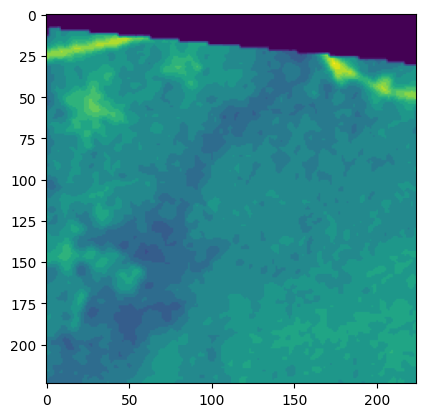

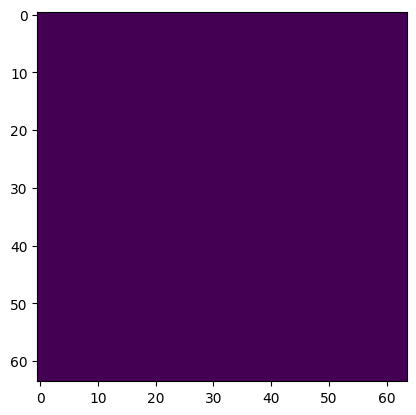

torch.Size([9, 224, 224])


In [6]:
# # Display image and label.
train_features = next(iter(trainLoader))
# print(f"Feature batch shape: {train_features.size()}")
img = train_features[0]
img = img[0:1, 0:3, :, :].squeeze()
maskimg = train_features[1]
print("shape")
print(maskimg)
maskimg = maskimg[0:1, :, :, :].squeeze()
# print(f"Feature batch shape: {img.size()}")
# #slice 3D array into 2D arrays to be displayed 

channel_test =1
img_tensor = transforms.ToPILImage()(img)
img_tensor = transforms_op(img_tensor)

plt.imshow(img_tensor[channel_test, :, :])
plt.show()
plt.imshow(maskimg)
plt.show()

imgs = train_features[0]
imgs = imgs[0:1, :, :, :].squeeze()
imgs = trans(imgs)
print(imgs.shape)

In [7]:
def infer(image_tensor, model, device):
    # Load and transform the image
#     image = Image.open(image_path).convert("RGB")
#     transformed_image = img_transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Make sure the model is in evaluation mode
    model.eval()

    with torch.no_grad():
        # Make prediction
        output = model(image_tensor)
        print(output.shape)
        # Get the predicted class for each pixel
        _, predicted = torch.max(output, 1)
    
    # Move prediction to cpu and convert to numpy array
    predicted = predicted.squeeze().cpu().numpy()

    return image_tensor.cpu().squeeze().permute(1, 2, 0).numpy(), predicted

In [8]:
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.transforms import functional as F
import numpy as np
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch import optim
from tqdm import tqdm
import torch.nn.functional as F
from scipy.ndimage import zoom
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def train(model, train_loader, criterion, optimizer, epoch):
    model.train()
    loop = tqdm(train_loader, total=len(train_loader))
    running_loss = 0
    correct = 0
    lossArr = []
    total_iou = 0

    for batch_idx, (data, target) in enumerate(loop):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        output = output.squeeze()
        target = target.squeeze()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        _, predicted = torch.max(output.data, 1)
        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss = loss.item())
        
        #IOU calculations
        output = output.detach().numpy()
        target = target.detach().numpy()
        intersection = np.logical_and(output, target)
        union = np.logical_or(output, target)
        iou_score = np.sum(intersection) / np.sum(union)
        total_iou += iou_score
        print(iou_score)
        
    
    tloss.append([epoch, running_loss/len(train_loader)])
    tacc.append([epoch, total_iou/len(train_loader)])
    print(f'\nTrain set: Average loss: {running_loss/len(train_loader):.4f}')
    print(f'\nTrain set: mIOU Score: {total_iou/len(train_loader):.4f}')


def validation(model, criterion, valid_loader, epoch):
    model.eval()
    running_loss = 0
    correct = 0
    i = 1
    lossArr = []
    total_iou = 0

    with torch.no_grad():
        loop = tqdm(valid_loader, total=len(valid_loader))
        for data, target in loop:
            data, target = data.to(device), target.to(device)
            output = model(data)
            print(output.size(), target.size())
            output = output.squeeze()
            target = target.squeeze()
            loss = criterion(output, target)
            running_loss += loss.item()
            lossArr.append([i, running_loss/i])
            i = i+1
            print(loss.item())
            _, predicted = torch.max(output.data, 1)
            
            #IOU calculations
            output = output.detach().numpy()
            target = target.detach().numpy()
            intersection = np.logical_and(output, target)
            union = np.logical_or(output, target)
            iou_score = np.sum(intersection) / np.sum(union)
            total_iou += iou_score
            print(iou_score)
            
        xbatch, xloss = zip(*lossArr)
        plt.plot(xbatch, xloss)
        plt.show()
        
    vloss.append([epoch, running_loss/len(train_loader)])
    vacc.append([epoch, total_iou/len(train_loader)])
    print(f'\nValidation set: Average loss: {running_loss/len(valid_loader):.4f}')
    print(f'\nTrain set: mIOU Score: {total_iou/len(train_loader):.4f}')


def infer(image_path, model, device, img_transform):
    # Load and transform the image
    image = Image.open(image_path).convert("RGB")
    transformed_image = img_transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Make sure the model is in evaluation mode
    model.eval()

    with torch.no_grad():
        # Make prediction
        output = model(transformed_image)

        # Get the predicted class for each pixel
        _, predicted = torch.max(output, 1)
    
    # Move prediction to cpu and convert to numpy array
    predicted = predicted.squeeze().cpu().numpy()

    return transformed_image.cpu().squeeze().permute(1, 2, 0).numpy(), predicted

In [9]:
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.transforms import functional as F
import numpy as np
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch import optim
from tqdm import tqdm
import torch.nn.functional as F
from scipy.ndimage import zoom
import matplotlib.pyplot as plt


# # Splitting data into train and validation sets
# train_imgs, valid_imgs = train_test_split(dataset.images, test_size=0.2, random_state=42)

# train_dataset = SegmentationDataset(img_dir= images, mask_dir=labels, num_classes = 5, img_transform=img_transform, mask_transform=mask_transform, images=train_imgs)
# valid_dataset = SegmentationDataset(img_dir=r"data\segmentation/train/imgs", mask_dir=r"data\segmentation/train/labels", num_classes = 5, img_transform=img_transform, mask_transform=mask_transform, images=valid_imgs)

# train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True) #, num_workers=4)
# valid_loader = DataLoader(valid_dataset, batch_size=2) #, num_workers=4)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
tloss = []
vloss = []
tacc = []
vacc = []

for epoch in range(NUM_EPOCHS):
    train(model, trainLoader, criterion, optimizer, epoch)
    validation(model, criterion, testLoader, epoch)

xbatch, xloss = zip(*tloss)
plt.plot(xbatch, xloss)
plt.show()

ybatch, yloss = zip(*vloss)
plt.plot(ybatch, yloss)
plt.show()

abatch, aloss = zip(*tacc)
plt.plot(abatch, aloss)
plt.show()

bbatch, bloss = zip(*vacc)
plt.plot(bbatch, bloss)
plt.show()



  0%|                                                     | 0/109 [00:00<?, ?it/s]

torch.Size([32, 9, 224, 224])


Epoch 1:   1%|▏                        | 1/109 [00:09<16:38,  9.24s/it, loss=40.5]

0.17354583740234375
torch.Size([32, 9, 224, 224])


Epoch 1:   2%|▍                        | 2/109 [00:17<15:38,  8.77s/it, loss=32.3]

0.14020538330078125
torch.Size([32, 9, 224, 224])


Epoch 1:   3%|▋                        | 3/109 [00:24<14:05,  7.98s/it, loss=16.7]

0.08016204833984375
torch.Size([32, 9, 224, 224])


Epoch 1:   4%|▉                        | 4/109 [00:32<13:36,  7.77s/it, loss=20.1]

0.09844207763671875
torch.Size([32, 9, 224, 224])


Epoch 1:   5%|█▏                       | 5/109 [00:39<13:07,  7.57s/it, loss=18.2]

0.08003997802734375
torch.Size([32, 9, 224, 224])


Epoch 1:   6%|█▍                       | 6/109 [00:46<12:49,  7.48s/it, loss=40.4]

0.1765594482421875
torch.Size([32, 9, 224, 224])


Epoch 1:   6%|█▍                       | 6/109 [00:51<14:50,  8.65s/it, loss=40.4]


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), 'weights/segmentation_model.pt')

In [ ]:
# # Perform inference
# model.eval()
# with torch.no_grad():
#     output = model(img_tensor)
# model.load_state_dict(torch.load(model_weights), strict=False)
# weights = r"dinov2_vitb14_linear_head.pth"
# model = model.to(DEVICE)
# # Get the predicted class for each pixel
# predicted = torch.max(output, 1)

# print("hello")
    
# # Move prediction to cpu and convert to numpy array

In [ ]:
# model.forward_features(img_tensor)["x_norm_patchtokens"].shape

In [ ]:
oimgs = imgs.unsqueeze(0)
plt.imshow(oimgs[0,1,:,:])
plt.show()
model.eval()
with torch.no_grad():
    # Make prediction
    output = model(oimgs)
    print("output")
    print(output)
    print(output.squeeze().shape, maskimg.shape)
    loss = criterion(output.squeeze(), maskimg)
    print(loss.item())
    # Get the predicted class for each pixel
    _, predicted = torch.max(output, 1,)
    print(predicted.shape)

# Move prediction to cpu and convert to numpy array
print(predicted)

In [ ]:
print(output.squeeze().size())
plt.imshow(img_tensor[channel_test, :, :])
plt.imshow(output.squeeze(), alpha=1)  # Overlay the mask on the image with transparency
plt.show()

In [ ]:
plt.imshow(output.squeeze()[0, :, :])

In [ ]:
# Used https://github.com/itsprakhar/Downstream-Dinov2/blob/main/demo.ipynb, https://github.com/purnasai/Dino_V2/blob/main/2.PCA_visualization.ipynb
transformed_image, predicted_mask = infer(imgs, model, DEVICE)
# Display the image and the mask
plt.imshow(transformed_image[:,:,1])
print(transformed_image.shape)
#plt.imshow(predicted_mask, alpha=1)  # Overlay the mask on the image with transparency
plt.show()